In [2]:
from document_preprocessor import SplitTokenizer, RegexTokenizer, SpaCyTokenizer
import time
import json
import gzip
import matplotlib.pyplot as plt
import seaborn as sns  
from tqdm import tqdm
from indexing import Indexer, IndexType
import sys
import pandas as pd
from ranker import Ranker, RelevanceScorer, WordCountCosineSimilarity, TF_IDF, BM25, PivotedNormalization, DirichletLM, LengthNormalizedScorer
from relevance import run_relevance_tests, map_score, ndcg_score

## Problem 2

In [9]:
DATASET_PATH = 'data/wikipedia_200k_dataset.jsonl.gz'
mwe_path = 'data/multi_word_expressions.txt'
mwe_list = []
with open(mwe_path, 'r') as f: 
    lines = f.readlines()
    for line in lines:
        mwe_list.append(line.strip())
    
def open_file(dataset_path):
    if dataset_path.endswith('.gz'):
        return gzip.open(dataset_path, 'rt', encoding='utf-8')
    else:
        return open(dataset_path, 'r', encoding='utf-8')
    
def load_documents(file_path=DATASET_PATH, num_docs=1000):
    documents = []
    with open_file(file_path) as f:
        for i, line in enumerate(f):
            if i>= num_docs:
                break
            doc = json.loads(line)
            documents.append(doc)
    return documents

documents = load_documents()

split_tokenizer = SplitTokenizer()
regex_tokenizer = RegexTokenizer()
spacy_tokenizer = SpaCyTokenizer()
tokenizers = {
    "SplitTokenizer" : split_tokenizer,
    "RegexTokenizer" : regex_tokenizer,
    "SpaCyTokenizer" : spacy_tokenizer
}
def tokenize_docs(tokenizer, documents):
    start_time = time.time()
    for doc in tqdm(documents):
        tokenizer.tokenize(doc['text'])
    end_time = time.time()
    time_used = end_time - start_time
    return time_used

for type, tokenizer in tokenizers.items():
    time_used = tokenize_docs(tokenizer, documents)
    print(f"Tokenizer {type} use
          s {time_used}:.2f seconds.")

100%|██████████| 1000/1000 [00:00<00:00, 2185.63doc/s]


Tokenizer SplitTokenizer uses 0.49849390983581543:.2f seconds.


100%|██████████| 1000/1000 [00:01<00:00, 975.75doc/s]


Tokenizer RegexTokenizer uses 1.0257129669189453:.2f seconds.


100%|██████████| 1000/1000 [07:30<00:00,  2.22doc/s]

Tokenizer SpaCyTokenizer uses 450.89839696884155:.2f seconds.


100%|██████████| 1000/1000 [06:53<00:00,  2.42doc/s]


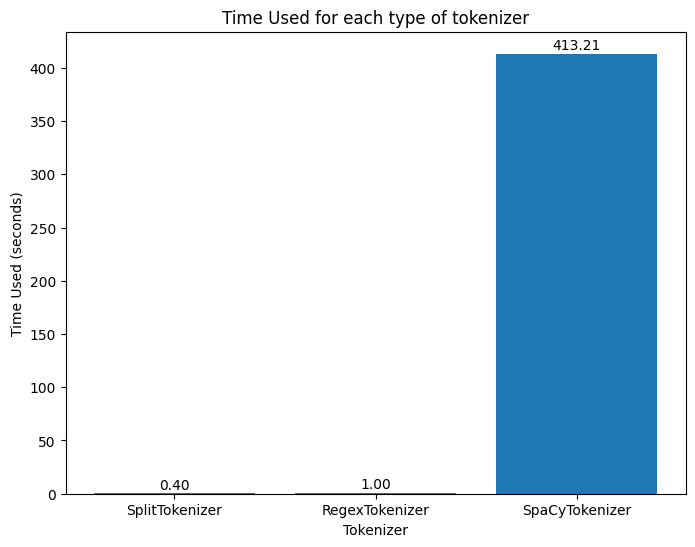

In [23]:
tokenizers = {
    "SplitTokenizer" : split_tokenizer,
    "RegexTokenizer" : regex_tokenizer,
    "SpaCyTokenizer" : spacy_tokenizer
}
times = {}
for type, tokenizer in tokenizers.items():
    time_used = tokenize_docs(tokenizer, documents)
    times[type] = time_used
    
preprocessors = list(times.keys())
times = list(times.values())

plt.figure(figsize=(8, 6))

plt.bar(preprocessors, times)  
plt.xlabel('Tokenizer')
plt.ylabel('Time Used (seconds)')
plt.title('Time Used for each type of tokenizer')
for index, value in enumerate(times):
    plt.text(index, value + max(times)*0.01, f"{value:.2f}", ha='center')
plt.show()

In [28]:
total_docs = 200000
average_times = {name: time / 1000 for name, time in zip(tokenizers.keys(), times)}
estimated_total_times = {name: avg_time * total_docs for name, avg_time in average_times.items()}
estimated_total_times_hours = {name: time_sec / 3600 for name, time_sec in estimated_total_times.items()}

for name, time_sec in estimated_total_times.items():
    print(f"Estimate time for {name} to tokenize {total_docs} documents: {time_sec / 3600:.2f} hours.")

Estimate time for SplitTokenizer to tokenize 200000 documents: 0.02 hours.
Estimate time for RegexTokenizer to tokenize 200000 documents: 0.06 hours.
Estimate time for SpaCyTokenizer to tokenize 200000 documents: 22.96 hours.


From the results shown above, we can find that the SplitTokenizer is the fastest one. But it's simple since it only splits the document based on the whitespace, therefore, the accuracy of this tokenizer may be very low.

For the RegexTokenizer, it's speed is moderate and has a higher accuracy of splitting the tokens.

SpacyTokenizer takes too long to finish the tokenizer and is very inefficient. But since it use the NLP methodology, it has high accuracy, can process more complex document.

In my opinion, considering both efficiency and accuracy, I would choose RegexTokenizer. But if some special situation that needs me to deal with very complex documents, the SpacyTokenizer may be preferred.

## Problem 5


Indexing 10 documents using BasicInvertedIndex...
Indexing time: 0.13 seconds
Index size: 6.20 MB

Indexing 100 documents using BasicInvertedIndex...
Indexing time: 0.90 seconds
Index size: 26.78 MB

Indexing 1000 documents using BasicInvertedIndex...
Indexing time: 3.99 seconds
Index size: 97.40 MB

Indexing 10000 documents using BasicInvertedIndex...
Indexing time: 25.39 seconds
Index size: 368.64 MB

Indexing 10 documents using PositionalIndex...
Indexing time: 0.13 seconds
Index size: 16.32 MB

Indexing 100 documents using PositionalIndex...
Indexing time: 1.31 seconds
Index size: 96.40 MB

Indexing 1000 documents using PositionalIndex...
Indexing time: 6.01 seconds
Index size: 420.50 MB

Indexing 10000 documents using PositionalIndex...
Indexing time: 58.38 seconds
Index size: 1667.75 MB


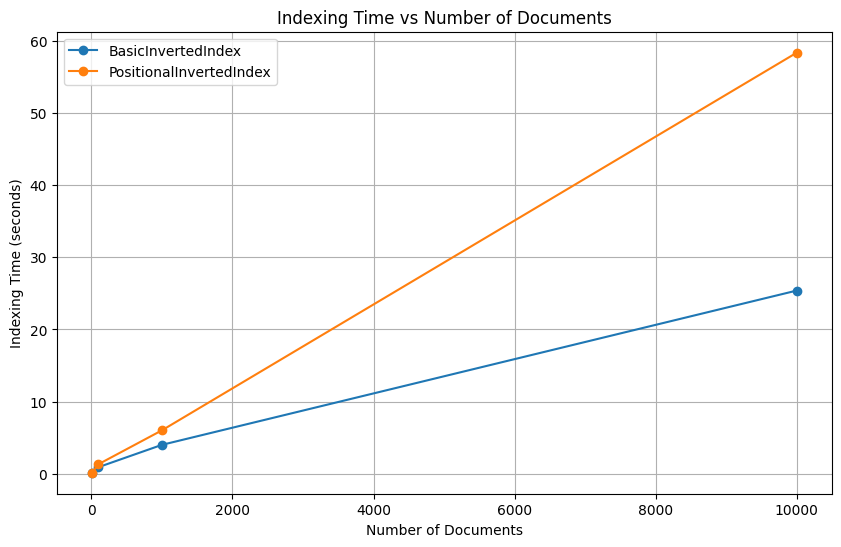

In [44]:
def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Mark as seen
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif isinstance(obj, (list, set, tuple)):
        size += sum([get_size(i, seen) for i in obj])
    return size

def measure_indexing(index_type, num_docs, tokenizer):
    print(f"\nIndexing {num_docs} documents using {index_type.value}...")
    start_time = time.time()

    index = Indexer.create_index(
        index_type=index_type,
        dataset_path=DATASET_PATH,
        document_preprocessor=tokenizer,
        text_key='text',
        stopwords=[],
        minimum_word_frequency=0,
        max_docs=num_docs
    )

    time_used = time.time() - start_time
    index_size = get_size(index)

    print(f"Indexing time: {time_used:.2f} seconds")
    print(f"Index size: {index_size / (1024 * 1024):.2f} MB")

    return time_used, index_size

def plot_results(index_times):
    plt.figure(figsize=(10, 6))
    
    for index_type, times in index_times.items():
        docs, elapsed_times = zip(*times)  # Unpack documents and times
        plt.plot(docs, elapsed_times, marker='o', label=index_type)
    
    plt.xlabel('Number of Documents')
    plt.ylabel('Indexing Time (seconds)')
    plt.title('Indexing Time vs Number of Documents')
    plt.legend()
    plt.grid(True)
    plt.show()

tokenizer = RegexTokenizer()
doc_counts = [10, 100, 1000, 10000]

index_times = {
    'BasicInvertedIndex': [],
    'PositionalInvertedIndex': []  # Ensure the correct name here
}

for index_type in [IndexType.BasicInvertedIndex, IndexType.PositionalIndex]:
    index_name = 'PositionalInvertedIndex' if index_type == IndexType.PositionalIndex else 'BasicInvertedIndex'
    
    for num_docs in doc_counts:
        time_used, _ = measure_indexing(index_type, num_docs, tokenizer)
        index_times[index_name].append((num_docs, time_used))  # Use index_name to ensure consistent key

plot_results(index_times)



Indexing 10 documents using BasicInvertedIndex...
Indexing time: 0.14 seconds
Index size: 6.20 MB

Indexing 100 documents using BasicInvertedIndex...
Indexing time: 0.78 seconds
Index size: 26.78 MB

Indexing 1000 documents using BasicInvertedIndex...
Indexing time: 4.02 seconds
Index size: 97.40 MB

Indexing 10000 documents using BasicInvertedIndex...
Indexing time: 22.82 seconds
Index size: 368.64 MB

Indexing 10 documents using PositionalIndex...
Indexing time: 0.13 seconds
Index size: 16.32 MB

Indexing 100 documents using PositionalIndex...
Indexing time: 1.61 seconds
Index size: 96.40 MB

Indexing 1000 documents using PositionalIndex...
Indexing time: 6.77 seconds
Index size: 420.50 MB

Indexing 10000 documents using PositionalIndex...
Indexing time: 53.62 seconds
Index size: 1667.75 MB


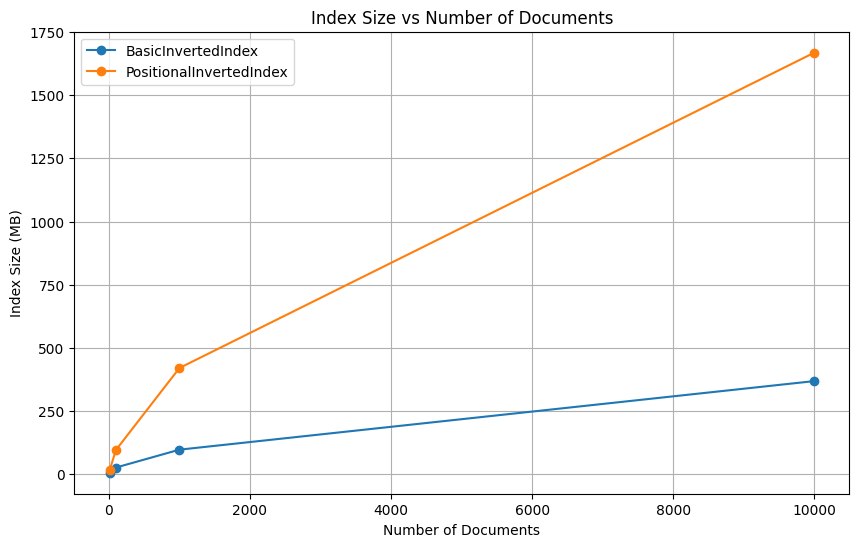

In [46]:
def plot_index_size(index_sizes):
    plt.figure(figsize=(10, 6))
    
    for index_type, sizes in index_sizes.items():
        docs, memory_sizes = zip(*sizes)  # Unpack documents and memory sizes
        plt.plot(docs, [size / (1024 * 1024) for size in memory_sizes], marker='o', label=index_type)  # Convert to MB
    
    plt.xlabel('Number of Documents')
    plt.ylabel('Index Size (MB)')
    plt.title('Index Size vs Number of Documents')
    plt.legend()
    plt.grid(True)
    plt.show()

# Structure to store index sizes for plotting
index_sizes = {
    'BasicInvertedIndex': [],
    'PositionalInvertedIndex': []
}

# Measure and collect both time and size for different document counts and index types
for index_type in [IndexType.BasicInvertedIndex, IndexType.PositionalIndex]:
    index_name = 'PositionalInvertedIndex' if index_type == IndexType.PositionalIndex else 'BasicInvertedIndex'
    
    for num_docs in doc_counts:
        _, size_used = measure_indexing(index_type, num_docs, tokenizer)
        index_sizes[index_name].append((num_docs, size_used))  # Store the document count and index size

# Plot index size results
plot_index_size(index_sizes)


In [49]:
def estimate_full_collection_positional(index_times, index_sizes, full_doc_count=200000):
    doc_counts = [10, 100, 1000, 10000]
    
    times = [time for _, time in index_times['PositionalInvertedIndex']]
    sizes = [size for _, size in index_sizes['PositionalInvertedIndex']]
    
    time_per_doc = times[-1] / doc_counts[-1]  
    estimated_time = time_per_doc * full_doc_count
    
    size_per_doc = sizes[-1] / doc_counts[-1]  
    estimated_size = size_per_doc * full_doc_count
    
    print(f"Estimated indexing time for {full_doc_count} documents using PositionalInvertedIndex: {estimated_time / 3600:.2f} hours")
    print(f"Estimated index size for {full_doc_count} documents using PositionalInvertedIndex: {estimated_size / (1024 * 1024):.2f} MB")

tokenizer = RegexTokenizer()

# Collecting times and sizes for PositionalInvertedIndex
index_times = {
    'PositionalInvertedIndex': []
}

index_sizes = {
    'PositionalInvertedIndex': []
}

doc_counts = [10, 100, 1000, 10000]

# Measure indexing time and size for each document count for PositionalInvertedIndex
for num_docs in doc_counts:
    time_used, size_used = measure_indexing(IndexType.PositionalIndex, num_docs, tokenizer)
    index_times['PositionalInvertedIndex'].append((num_docs, time_used))
    index_sizes['PositionalInvertedIndex'].append((num_docs, size_used))

# Estimating time and size for the full collection (200,000 documents)
estimate_full_collection_positional(index_times, index_sizes)



Indexing 10 documents using PositionalIndex...
Indexing time: 0.14 seconds
Index size: 16.32 MB

Indexing 100 documents using PositionalIndex...
Indexing time: 2.24 seconds
Index size: 96.39 MB

Indexing 1000 documents using PositionalIndex...
Indexing time: 6.48 seconds
Index size: 420.50 MB

Indexing 10000 documents using PositionalIndex...
Indexing time: 57.08 seconds
Index size: 1667.75 MB
Estimated indexing time for 200000 documents using PositionalInvertedIndex: 0.32 hours
Estimated index size for 200000 documents using PositionalInvertedIndex: 33354.91 MB


### Conclusion
Based on the estimation, the index size for 200,000 documents using the PositionalInvertedIndex would be approximately 33.35 GB. Since my laptop only has 8GB of RAM, it cannot fit into memory on my computer. 

## Problem 6
I design a ranker based on the **Length Normalization Axiom**, which focuses on adjusting for document length in order to avoid overly long documents being favored unfairly as learned in class.

In this ranker, I aim to reduce the bias toward longer documents by penalizing them. This is based on the idea that longer documents, which naturally contain more words, might falsely appear more relevant if not adjusted. I'll combine **TF-IDF** with a length normalization factor to ensure that the length of the document does not disproportionately affect its score.


1. **Term Frequency Axiom**: I'll still rely on **TF** (Term Frequency) to give weight to terms that appear more often in a document.
   
2. **Document Frequency Axiom**: I’ll use **IDF** (Inverse Document Frequency) to ensure that terms that appear in fewer documents are considered more important.

3. **Length Normalization Axiom**: The main addition here is that I penalize documents based on their length. Documents that are much longer than the average will have their scores reduced, while shorter documents will be normalized upwards.

### Custom Scoring Formula:

$$
\text{Score} = \sum_{w_i \in q \cap d} \left( \text{TF-IDF}(w_i) \right) \times \frac{1}{\text{length\_penalty}(d)}
$$

Where:
- **TF-IDF** is the standard term frequency-inverse document frequency calculation.
   - As with traditional TF-IDF, the term frequency and inverse document frequency are calculated to score the relevance of the document for each query term.
- **length_penalty(d)** is a penalty factor for long documents, which is computed as a ratio of the document length to the average document length.
   - A length normalization penalty is applied based on how much the document's length deviates from the average document length in the corpus.
   - If a document is longer than the average, its score will be penalized to prevent overly long documents from dominating.
   - If a document is shorter than the average, its score is boosted proportionally, to give shorter but highly relevant documents a fair chance.

### Thought Process:

1. **Term Frequency Axiom**:
   - The ranker ensures that documents with a higher term frequency are favored, but this is logarithmically scaled to avoid overwhelming the results.

2. **Document Frequency Axiom**:
   - Terms that appear in fewer documents are considered more relevant, using the standard IDF principle.

3. **Length Normalization Axiom**:
   - This ranker ensures that long documents do not receive unfairly high scores just because they contain more words. It adjusts scores based on document length relative to the average document length, favoring more concise but relevant documents.



## Problem 9

Evaluating WordCountCosineSimilarity...


Evaluating: 100%|██████████| 37/37 [00:03<00:00, 11.39it/s]


Evaluating TF_IDF...


Evaluating: 100%|██████████| 37/37 [00:03<00:00, 10.79it/s]


Evaluating BM25...


Evaluating: 100%|██████████| 37/37 [00:04<00:00,  7.61it/s]


Evaluating PivotedNormalization...


Evaluating: 100%|██████████| 37/37 [00:04<00:00,  8.31it/s]


Evaluating DirichletLM...


Evaluating: 100%|██████████| 37/37 [00:03<00:00,  9.42it/s]


Evaluating LengthNormalizedScorer...


Evaluating: 100%|██████████| 37/37 [00:03<00:00,  9.33it/s]


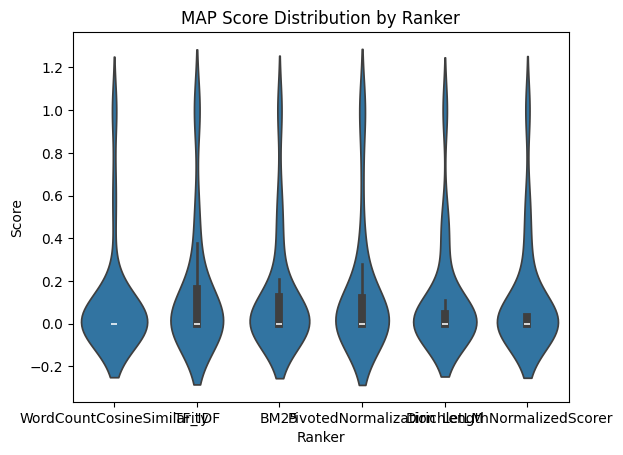

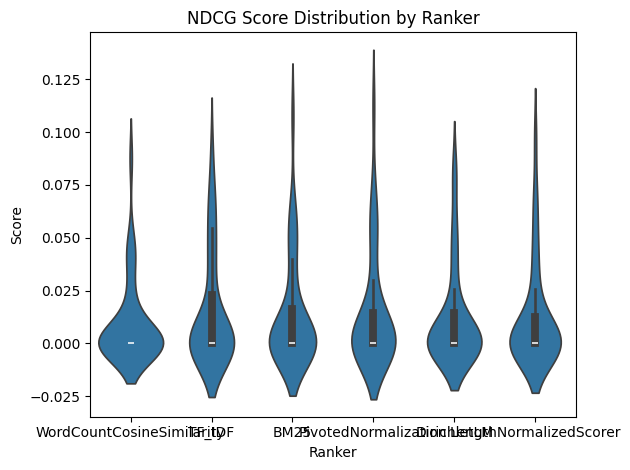

Summarized Average Performance for Each Ranker:
ranker        BM25  DirichletLM  LengthNormalizedScorer  PivotedNormalization  \
avg_map   0.124364     0.112755                0.118187              0.141605   
avg_ndcg  0.013572     0.011418                0.011999              0.014752   

ranker      TF_IDF  WordCountCosineSimilarity  
avg_map   0.144257                   0.100201  
avg_ndcg  0.014989                   0.009076  


In [5]:
DATASET_PATH = 'data/wikipedia_200k_dataset.jsonl.gz'

basic_index = Indexer.create_index(
    index_type=IndexType.BasicInvertedIndex, 
    dataset_path=DATASET_PATH, 
    document_preprocessor=RegexTokenizer(),  # Initialize RegexTokenizer here
    stopwords=[], 
    minimum_word_frequency=50, 
    text_key='text', 
    max_docs=-1, 
    load_file_dir='__cache__'
)


relevance_file = 'data/relevance.test.csv'

rankers = {
    'WordCountCosineSimilarity': Ranker(
        index=basic_index,
        document_preprocessor=RegexTokenizer(),  # Initialize tokenizer here
        stopwords=[],
        scorer=WordCountCosineSimilarity(index=basic_index),
    ),
    'TF_IDF': Ranker(
        index=basic_index,
        document_preprocessor=RegexTokenizer(),
        stopwords=[],
        scorer=TF_IDF(index=basic_index),
    ),
    'BM25': Ranker(
        index=basic_index,
        document_preprocessor=RegexTokenizer(),
        stopwords=[],
        scorer=BM25(index=basic_index),
    ),
    'PivotedNormalization': Ranker(
        index=basic_index,
        document_preprocessor=RegexTokenizer(),
        stopwords=[],
        scorer=PivotedNormalization(index=basic_index),
    ),
    'DirichletLM': Ranker(
        index=basic_index,
        document_preprocessor=RegexTokenizer(),
        stopwords=[],
        scorer=DirichletLM(index=basic_index),
    ),
    'LengthNormalizedScorer': Ranker(
        index=basic_index,
        document_preprocessor=RegexTokenizer(),
        stopwords=[],
        scorer=LengthNormalizedScorer(index=basic_index),
    )
}

results = {
    'ranker': [],
    'query_id': [],
    'MAP': [],
    'NDCG': []
}

# Iterate over all rankers and collect individual query-level scores
for ranker_name, ranker in rankers.items():
    print(f"Evaluating {ranker_name}...")

    # Run relevance tests for this ranker
    scores = run_relevance_tests(relevance_file, ranker)

    # Store individual query-level MAP and NDCG scores
    for query_id, (map_score_value, ndcg_score_value) in enumerate(zip(scores['map_list'], scores['ndcg_list'])):
        results['ranker'].append(ranker_name)
        results['query_id'].append(query_id)
        results['MAP'].append(map_score_value)
        results['NDCG'].append(ndcg_score_value)

# Convert the results to a DataFrame for easy visualization
df_results = pd.DataFrame(results)

# Prepare the data in long format for plotting
plot_data = []
for i, row in df_results.iterrows():
    plot_data.append({'Ranker': row['ranker'], 'Metric': 'MAP', 'Score': row['MAP']})
    plot_data.append({'Ranker': row['ranker'], 'Metric': 'NDCG', 'Score': row['NDCG']})

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)


# Plot for MAP
sns.violinplot(x="Ranker", y="Score", data=plot_df[plot_df['Metric'] == 'MAP'])
plt.title("MAP Score Distribution by Ranker")
plt.show()


# Plot for NDCG
  
sns.violinplot(x="Ranker", y="Score", data=plot_df[plot_df['Metric'] == 'NDCG'])
plt.title("NDCG Score Distribution by Ranker")

plt.tight_layout()
plt.show()

summary_table = df_results.groupby('ranker').agg(
    avg_map=('MAP', 'mean'),
    avg_ndcg=('NDCG', 'mean')
).reset_index()

# Transpose the table to have two rows: one for MAP and one for NDCG
summary_table_transposed = summary_table.set_index('ranker').T

# Print the summarized table
print("Summarized Average Performance for Each Ranker:")
print(summary_table_transposed)

MAP Distribution: BM25 and PivotedNormalization show wider distributions with some high scores, indicating that they are more effective for certain queries. Rankers like WordCountCosineSimilarity, DirichletLM tend and my customized ranker to perform less effectively, with lower median and compressed distributions.

NDCG Distribution: The NDCG scores are lower overall compared to MAP, indicating that while the rankers are retrieving some relevant documents, the order of these documents might not align well with the ground-truth relevance scores. TF-IDF, BM25 and Pivoted Normalization show better distributions for NDCG compared to other rankers, which suggests that they provide better-ordered results. Also, my ranker performs well, too.

In general, BM25 and Pivoted Normalization appear to perform better in both MAP and NDCG, while WordCountCosineSimilarity struggles more, particularly in MAP, making the relevance functions somewhat varied in terms of performance.
